# Package `nelpy` example usage

The `nelpy` package is based on `python-vdmlab` (https://github.com/vandermeerlab/python-vdmlab) by Emily Irvine, but has been heavily modified.

In [1]:
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

sys.path.insert(0, '../')

import nelpy as nel
from nelpy.objects import *

1. create a spiketrain with samples and fs
1. create a spiketrain with time
1. create a spiketrain with an explicit epoch array (and explain how implicit epoch arrays work)
1. create a spiketrain with an explicit epoch array that is smaller than the extent of the spikes
1. shift a spiketrain
1. slice a spiketrain with a slice object
1. slice a spiketrain with an epoch array
1. create an epoch array with samples
1. create an epoch array with time
1. create an epoch array with fixed duration
1. create an epoch array with overlapping epochs
1. combine two epoch arrays with the same sampling rate
1. combine two epoch arrays with different sampling rates
1. change the sampling rate of an object
1. change the sampling rate of an object without changing samples / time
1. pretty object representation: cell_type, metadata, label
1. metadata propagation
1. friendly warnings: empty intersection, change of fs, 
1. recommendations: always use fs, and update metadata dict when creating new objects

### Create a spiketrain with `samples` and `fs`

Spiketrains can be initialized either with an array of samples and an associated sampling rate (recommended) or with an array of spike times in seconds.

Specifying a sampling rate helps to make objects with different sampling rates (e.g. wideband LFP, spike times, video tracking, etc.) all work together seamlessly.

A spiketrain also has an associated epoch array on which the spiketrain is defined and valid. This can be inferred implicitly (as in this first example), but is also recommended to be specified explicitly to facilitate easier analysis later on (we'll have examples of this). The basic idea is simply that just because we don't have spikes in a particular [time] segment of the spiketrain does not mean that the cell didn't fire there---it may simply mean that the spiketrain is not defined on that segment. This 'support' of the spiketrain should be used whenever we want to calculate things like average firing rate, etc.

In [2]:
# create example spike times in samples
stdata = np.array([1, 2, 3, 4, 5, 6, 6.5, 7, 8, 10, 18, 18.5, 23, 25])
st = SpikeTrain(stdata, fs=10)

Now `st` is a spiketrain with 14 spikes, which we can easily verify by either printing out our `st` object, or by inspecting its `n_spikes` property:

In [3]:
print(st)
print('st has {0} spikes'.format(st.n_spikes))

<SpikeTrain: 14 spikes at 10 Hz>
st has 14 spikes


..\nelpy\objects.py:934: UserWarning: Cell type has not yet been specified!
  warnings.warn("Cell type has not yet been specified!")


Here we can see that (1) printing out `st` actually gives us some additional information, namely the sampling rate. Also notice the warning that was issued about the cell type not having been specified. Warnings can be ignored and should not affect your analyses, but they can be really useful to make sure that you have all the recommended info in your objects, and that you don't do something that you don't intend to do.

First, let's quickly get back to the samples-vs-time issue. In general it is highly recommended to create objects using sample numbers and an associated sampling rate (`fs`). However, sample numbers are not strictly required to be integers, but the association between samples and time is simply: time = samples / fs. Each spiketrain object therefore has both a `samples` and a `time` object. If samples == time, then they both point to the same memory. 

**TODO:** One consideration is to change time to be evaluated lazily, instead of storing it like I do at present. Less memory requirements. Could be useful for large spiketrains. What are some other considerations?

Let's take a look at `st.samples` and `st.time`:

In [4]:
st.samples

array([  1. ,   2. ,   3. ,   4. ,   5. ,   6. ,   6.5,   7. ,   8. ,
        10. ,  18. ,  18.5,  23. ,  25. ])

In [5]:
st.time

array([ 0.1 ,  0.2 ,  0.3 ,  0.4 ,  0.5 ,  0.6 ,  0.65,  0.7 ,  0.8 ,
        1.  ,  1.8 ,  1.85,  2.3 ,  2.5 ])

As we can see, the correspondence is just as described above, namely time = samples / fs.

Without jumping ahead too far, notice that each spiketrain has a region of support on which it is defined. Because we did not specify this region of support, it was inferred automatically (default is [0, time-of-last-spike]), but it is better to specify this explicitly whenever possible. Having this support allows us to compute things like the average firing rate as follows:

In [6]:
print('The duration of st.support is {0:2.4} seconds.'.format(st.support.duration))
avgFiringRate = st.n_spikes / st.support.duration
print('Average firing rate: {0:2.4} Hz'.format(avgFiringRate))

The duration of st.support is 2.5 seconds.
Average firing rate: 5.6 Hz


Why is the support so useful? Well, consider a scenario where we defined the support to be when an animal was running faster than some threshold, so the support might have some gaps in it, and the duration is no longer equal to `st.support.stop - st.support.start`. If we had specified our support properly, then we would not have to change anything to compute the average firing rate of the spiketrain associated with this running behavior. Let's look at an example.

In [7]:
# define epochs during which animal was running
runEpoch = EpochArray(np.array([[0,3],[6,8], [24,25]]), fs=10)

st = SpikeTrain(stdata, fs=10, support=runEpoch)

..\nelpy\objects.py:564: UserWarning: ignoring spikes outside of spiketrain support
  'ignoring spikes outside of spiketrain support')


We obtain a friendly warning that the support that we explicitly specified would cause some spikes to be ignored. This is a useful warning, but in this case, that IS what we want to do, so let's move on.

Notice that the spikes contained in `st.samples` now fall nicely in the support region that we specified:

In [8]:
st.samples

array([  1. ,   2. ,   3. ,   6. ,   6.5,   7. ,   8. ,  25. ])

Also note that even though `st.support.start` and `st.support.stop` is EXACTLY the same as in our previous example, the duration is no longer simply `st.support.stop - st.support.start`.

In [9]:
print('st.support.stop - st.support.start = {0:2.4} seconds.'.format(st.support.stop - st.support.start))
print('The duration of st.support is {0:2.4} seconds.'.format(st.support.duration))
avgFiringRate = st.n_spikes / st.support.duration
print('Average firing rate: {0:2.4} Hz'.format(avgFiringRate))

st.support.stop - st.support.start = 2.5 seconds.
The duration of st.support is 0.6 seconds.
Average firing rate: 13.33 Hz


In [10]:
st.support

<EpochArray: 3 epochs> totaling 0.6 seconds

In [11]:
ep = EpochArray([])

In [12]:
stdata = np.array([1,2,3,4,5,6,6.5,7,8,10])
fs = 4
st = SpikeTrain(stdata, fs=fs)
st.cell_type = 'pyr'
ep1 = EpochArray([])
ep2 = EpochArray(np.array([[0,3],[7,10]]), fs=fs)
ep3 = EpochArray(np.array([[0,3],[8,15]]), fs=fs)
ep4 = EpochArray(np.array([[0,3],[17,20]]), fs=fs)
ep5 = EpochArray(np.array([[17,20]]), fs=fs)
ep6 = EpochArray(np.array([[-17,-10]]), fs=fs)
print('SpikeTrain')
print('==========')
print(st, st.support)
print('\nslicing with slice objects and integers')
print('==========')
print(st[:4], st[:4].support)
print(st[4:], st[4:].support)
print(st[4:50], st[4:50].support)
print(st[40:], st[40:].support)
print(st[-1], st[-1].support)
print(st[80], st[80].support)
print('\nslicing with EpochArrays')
print('==========')
print(st[ep1], st[ep1].support)
print(st[ep2], st[ep2].support)
print(st[ep3], st[ep3].support)
print(st[ep4], st[ep4].support)
print(st[ep5], st[ep5].support)
print(st[ep6], st[ep6].support)

SpikeTrain
<SpikeTrain[pyr]: 10 spikes at 4 Hz> <EpochArray: 1 epoch> totaling 2.5 seconds

slicing with slice objects and integers
<SpikeTrain[pyr]: 4 spikes at 4 Hz> <EpochArray: 1 epoch> totaling 0.75 seconds
<SpikeTrain[pyr]: 6 spikes at 4 Hz> <EpochArray: 1 epoch> totaling 1.25 seconds
<SpikeTrain[pyr]: 6 spikes at 4 Hz> <EpochArray: 1 epoch> totaling 1.25 seconds
<empty SpikeTrain> <empty EpochArray>
<SpikeTrain[pyr]: 1 spikes at 4 Hz> <EpochArray: 1 epoch> totaling 0.0 seconds
<empty SpikeTrain> <empty EpochArray>

slicing with EpochArrays
<empty SpikeTrain> <empty EpochArray>
<SpikeTrain[pyr]: 6 spikes at 4 Hz> <EpochArray: 2 epochs> totaling 1.5 seconds
<SpikeTrain[pyr]: 5 spikes at 4 Hz> <EpochArray: 2 epochs> totaling 1.25 seconds
<SpikeTrain[pyr]: 3 spikes at 4 Hz> <EpochArray: 1 epoch> totaling 0.75 seconds
<empty SpikeTrain> <empty EpochArray>
<empty SpikeTrain> <empty EpochArray>


..\nelpy\objects.py:702: UserWarning: meta data is not available
  warnings.warn("meta data is not available")
..\nelpy\objects.py:165: UserWarning: meta data is not available
  warnings.warn("meta data is not available")


In [18]:
ep2

<empty EpochArray>

### A somewhat realistic example

In [13]:
from numpy.random import random_sample
a = 0
b = 1000
N = int(1e7)
stdata = (b - a) * random_sample((N,)) + a
stdata.sort()

In [14]:
# %%timeit
st = SpikeTrain(stdata, fs=10)
st

..\nelpy\objects.py:691: UserWarning: Cell type has not yet been specified!
  warnings.warn("Cell type has not yet been specified!")


<SpikeTrain: 10000000 spikes at 10 Hz>

In [15]:
st[:1e6].support

..\nelpy\objects.py:606: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  [self.samples[start], self.samples[stop]]), fs=self.fs, meta=self.meta)
..\nelpy\objects.py:662: UserWarning: meta data is not available
  warnings.warn("meta data is not available")
..\nelpy\objects.py:607: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return SpikeTrain(self.samples[idx],
..\nelpy\objects.py:651: UserWarning: Cell type has not yet been specified!
  warnings.warn("Cell type has not yet been specified!")


<EpochArray: 1 epoch> totaling 10.0218923511 seconds

In [19]:
N = int(1e3)
epdata = (b - a) * random_sample((N,)) + a
epdata.sort()
epdata = epdata.reshape((N // 2, 2))

In [20]:
epoch = EpochArray(epdata, fs=10)

In [23]:
st2 = st[epoch] # this eats up all my memory :( ... approx 9 GB for a 500 EpochArray, and about 1 minute

..\nelpy\objects.py:125: UserWarning: meta data is not available
  warnings.warn("meta data is not available")
..\nelpy\objects.py:651: UserWarning: Cell type has not yet been specified!
  warnings.warn("Cell type has not yet been specified!")
..\nelpy\objects.py:662: UserWarning: meta data is not available
  warnings.warn("meta data is not available")


In [29]:
st2

..\nelpy\objects.py:651: UserWarning: Cell type has not yet been specified!
  warnings.warn("Cell type has not yet been specified!")


<SpikeTrain: 5168400 spikes at 10 Hz>

In [32]:
10000000 / 100 /60 /60 /24 # approx days for single SpikeTrain

1.1574074074074074

In [36]:
np.array([2,3,4]).ndim

1

## Visual examples

In [17]:
def plotEpochsHatch(ax, epochs, height=1, fc='c', ec='k', alpha=0.5):
    import matplotlib.patches as patches
    for start, stop in zip(epochs.starts, epochs.stops):
        ax.add_patch(
            patches.Rectangle(
                (start, 0),   # (x,y)
                stop - start ,          # width
                height,          # height
                hatch='////',
                facecolor=fc,
                edgecolor=ec,
                alpha=alpha
            )
        )
    ax.set_xlim([epochs.start, epochs.stop])


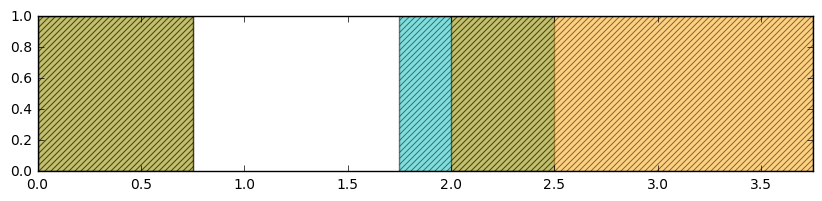

In [18]:
fig, ax = plt.subplots(1,1, figsize=(10, 2))
plotEpochsHatch(ax, ep2)
ax.set_xlim([0,3])
plotEpochsHatch(ax, ep3, fc='orange')

..\nelpy\objects.py:125: UserWarning: meta data is not available
  warnings.warn("meta data is not available")


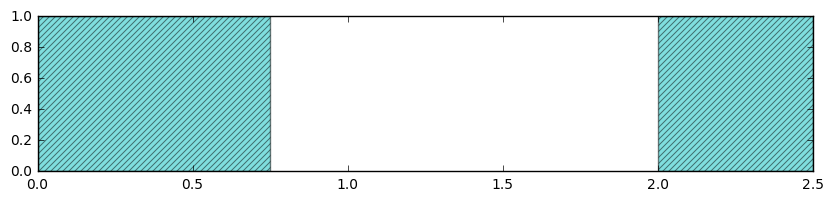

In [19]:
fig, ax = plt.subplots(1,1, figsize=(10, 2))
plotEpochsHatch(ax, ep2.intersect(ep3))

..\nelpy\objects.py:125: UserWarning: meta data is not available
  warnings.warn("meta data is not available")


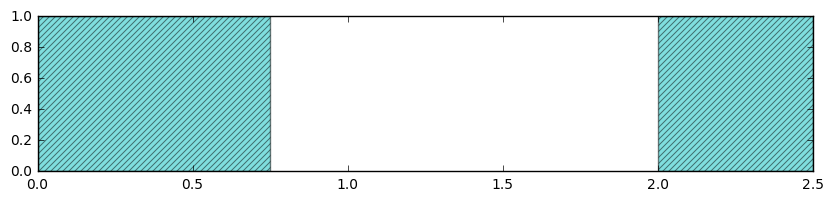

In [20]:
fig, ax = plt.subplots(1,1, figsize=(10, 2))
plotEpochsHatch(ax, ep3.intersect(ep2))

In [21]:
ep1 = EpochArray(np.array([[1,3],[2,6],[12,15]]), fs=3)
ep2 = EpochArray(np.array([[1,2],[4,6],[7,10]]), fs=1)
ep3 = EpochArray(np.array([[1,2],[4,6],[8,10]]), fs=2.2)
ep4 = EpochArray(np.array([1,2,4,6,8,10]),duration=0.1, fs=3)

(0, 10)

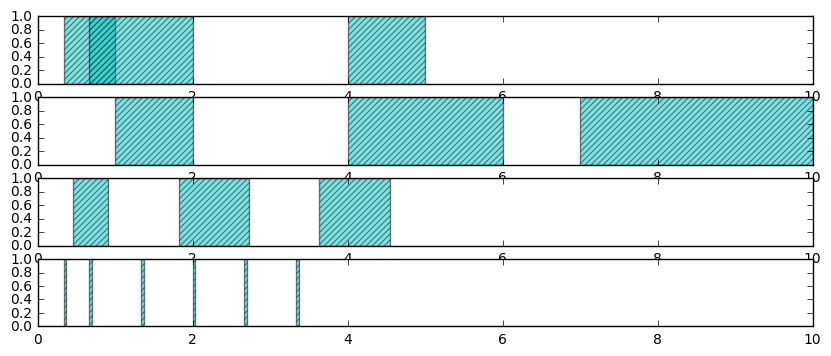

In [22]:
fig, axes = plt.subplots(4,1, figsize=(10, 4))
plotEpochsHatch(axes[0], ep1); axes[0].set_xlim([0, 10])
plotEpochsHatch(axes[1], ep2); axes[1].set_xlim([0, 10])
plotEpochsHatch(axes[2], ep3); axes[2].set_xlim([0, 10])
plotEpochsHatch(axes[3], ep4); axes[3].set_xlim([0, 10])

..\nelpy\objects.py:125: UserWarning: meta data is not available
  warnings.warn("meta data is not available")
..\nelpy\objects.py:305: UserWarning: sampling rates are different; intersecting along time only and throwing away fs
  'sampling rates are different; intersecting along time only and throwing away fs')
..\nelpy\objects.py:429: UserWarning: sampling rates are different; joining along time only and throwing away fs
  'sampling rates are different; joining along time only and throwing away fs')
..\nelpy\objects.py:136: UserWarning: No sampling frequency has been specified!
  warnings.warn("No sampling frequency has been specified!")


(0, 10)

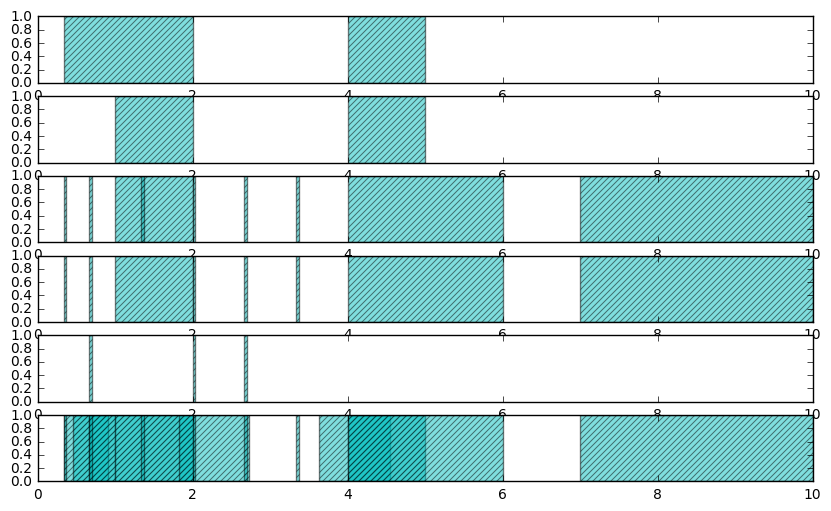

In [23]:
fig, axes = plt.subplots(6,1, figsize=(10, 6))
plotEpochsHatch(axes[0], ep1.merge()); axes[0].set_xlim([0, 10])
plotEpochsHatch(axes[1], ep2.intersect(ep1)); axes[1].set_xlim([0, 10])
plotEpochsHatch(axes[2], ep2.join(ep4)); axes[2].set_xlim([0, 10])
plotEpochsHatch(axes[3], ep2.join(ep4).merge()); axes[3].set_xlim([0, 10])
plotEpochsHatch(axes[4], ep3.intersect(ep4)); axes[4].set_xlim([0, 10])
plotEpochsHatch(axes[5], ep1.join(ep2).join(ep3).join(ep4)); axes[5].set_xlim([0, 10])

# WHY DID THE IMPLICIT MERGE NOT WORK ABOVE?

In [24]:
ep = ep1.join(ep2).join(ep3).join(ep4)

..\nelpy\objects.py:429: UserWarning: sampling rates are different; joining along time only and throwing away fs
  'sampling rates are different; joining along time only and throwing away fs')
..\nelpy\objects.py:136: UserWarning: No sampling frequency has been specified!
  warnings.warn("No sampling frequency has been specified!")


In [25]:
ep.time

array([[  0.33333333,   1.        ],
       [  0.33333333,   0.36666667],
       [  0.45454545,   0.90909091],
       [  0.66666667,   2.        ],
       [  0.66666667,   0.7       ],
       [  1.        ,   2.        ],
       [  1.33333333,   1.36666667],
       [  1.81818182,   2.72727273],
       [  2.        ,   2.03333333],
       [  2.66666667,   2.7       ],
       [  3.33333333,   3.36666667],
       [  3.63636364,   4.54545455],
       [  4.        ,   5.        ],
       [  4.        ,   6.        ],
       [  7.        ,  10.        ]])

In [26]:
ep.merge()

..\nelpy\objects.py:136: UserWarning: No sampling frequency has been specified!
  warnings.warn("No sampling frequency has been specified!")
..\nelpy\objects.py:125: UserWarning: meta data is not available
  warnings.warn("meta data is not available")


<EpochArray: 8 epochs> totaling 9.57878787879 seconds

In [27]:
ep.merge().merge()

..\nelpy\objects.py:136: UserWarning: No sampling frequency has been specified!
  warnings.warn("No sampling frequency has been specified!")
..\nelpy\objects.py:125: UserWarning: meta data is not available
  warnings.warn("meta data is not available")


<EpochArray: 4 epochs> totaling 7.79090909091 seconds

# merge() problem case:

<EpochArray: 15 epochs> totaling 11.4727272727 seconds
<EpochArray: 8 epochs> totaling 9.57878787879 seconds
<EpochArray: 4 epochs> totaling 7.79090909091 seconds


..\nelpy\objects.py:429: UserWarning: sampling rates are different; joining along time only and throwing away fs
  'sampling rates are different; joining along time only and throwing away fs')
..\nelpy\objects.py:136: UserWarning: No sampling frequency has been specified!
  warnings.warn("No sampling frequency has been specified!")
..\nelpy\objects.py:125: UserWarning: meta data is not available
  warnings.warn("meta data is not available")


(0, 10)

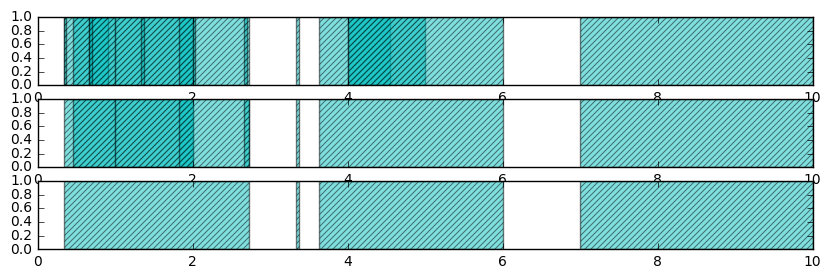

In [28]:
ep1 = EpochArray(np.array([[1,3],[2,6],[12,15]]), fs=3)
ep2 = EpochArray(np.array([[1,2],[4,6],[7,10]]), fs=1)
ep3 = EpochArray(np.array([[1,2],[4,6],[8,10]]), fs=2.2)
ep4 = EpochArray(np.array([1,2,4,6,8,10]),duration=0.1, fs=3)
ep = ep1.join(ep2).join(ep3).join(ep4)

print(ep)
print(ep.merge())
print(ep.merge().merge())

fig, axes = plt.subplots(3,1, figsize=(10, 3))

plotEpochsHatch(axes[0], ep); axes[0].set_xlim([0, 10])
plotEpochsHatch(axes[1], ep.merge()); axes[1].set_xlim([0, 10])
plotEpochsHatch(axes[2], ep.merge().merge()); axes[2].set_xlim([0, 10])

In [2]:
# create example spike times in samples
stdata = np.array([1, 2, 3, 4, 5, 6, 6.5, 7, 8, 10, 18, 18.5, 23, 25])
st = SpikeTrain(stdata, fs=10)

bst = BinnedSpikeTrain(st, ds=0.625)

..\nelpy\objects.py:184: UserWarning: meta data is not available
  warnings.warn("meta data is not available")


In [11]:
bst.isempty

False

In [10]:
st

..\nelpy\objects.py:935: UserWarning: Cell type has not yet been specified!
  warnings.warn("Cell type has not yet been specified!")


<SpikeTrain: 14 spikes at 10 Hz>

All but the last (righthand-most) bin is half-open. In other words, if bins is:

[1, 2, 3, 4]
then the first bin is [1, 2) (including 1, but excluding 2) and the second [2, 3). The last bin, however, is [3, 4], which includes 4.

In [2]:
st = np.array([9.1, 11, 13.4, 16.2])

In [3]:
bst = BinnedSpikeTrain(st)

TypeError: spiketrain must be a nelpy.SpikeTrain object.

In [19]:
16.2 - (16.2 % 0.5) + 0.5

16.5

In [53]:
st.support.start

0.0

In [54]:
st.support.time

array([[ 0. ,  2.5]])

In [6]:
def get_bins(ep, ds=0.5):
#     start = ep.start - (ep.start % ds)
#     start = ep.start - (ep.start / ds - floor(ep.start / ds)) # because e.g., 1 % 0.1 is messed up (precision error)
    start = ds * np.floor(ep.start / ds)
    num = np.ceil((ep.stop - start) / ds)
    stop = start + ds * num
    bins = np.linspace(start, stop, num+1)
    return bins

In [126]:
bins = get_bins(st.support, ds=0.8)
bins

array([ 0. ,  0.8,  1.6,  2.4,  3.2])

In [127]:
from math import floor
1 / 0.1 - floor(1 / 0.1)

0.0

In [12]:
ep2 = EpochArray(np.array([[1,2],[4,6],[7,10]]), fs=1)

In [13]:
st = SpikeTrain(stdata, fs=1, support=ep2)

..\nelpy\objects.py:808: UserWarning: ignoring spikes outside of spiketrain support
  'ignoring spikes outside of spiketrain support')


In [17]:
stdata = np.array([1, 2, 3, 4, 5, 6, 6.5, 7, 8, 10, 18, 18.5, 23, 25])
ep2 = EpochArray(np.array([[1,2],[4,6],[7,10]]), fs=1)
st = SpikeTrain(stdata, fs=1, support=ep2)
print(st.support.time)
bst = BinnedSpikeTrain(st, ds=2.8)

print(bst.bins)

array([[  1.,   2.],
       [  4.,   6.],
       [  7.,  10.]])

In [47]:
bst = BinnedSpikeTrain(st, ds=1)

..\nelpy\objects.py:184: UserWarning: meta data is not available
  warnings.warn("meta data is not available")


In [48]:
bst.bins

array([  1.,   2.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

In [49]:
bst.data

array([2, 1, 2, 1, 1, 1])

In [50]:
bst.centers

array([ 1.5,  4.5,  5.5,  7.5,  8.5,  9.5])

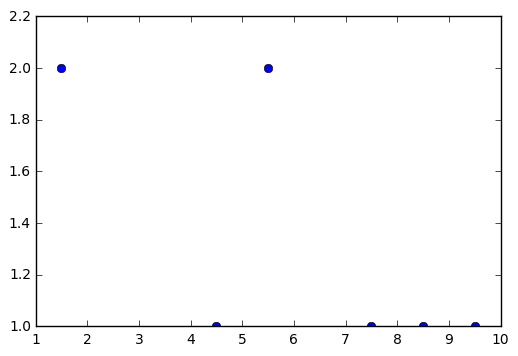

In [51]:
plt.plot(bst.centers, bst.data, 'o')

[[  1.   2.]
 [  4.   6.]
 [  7.  10.]]


..\nelpy\objects.py:808: UserWarning: ignoring spikes outside of spiketrain support
  'ignoring spikes outside of spiketrain support')
..\nelpy\objects.py:184: UserWarning: meta data is not available
  warnings.warn("meta data is not available")


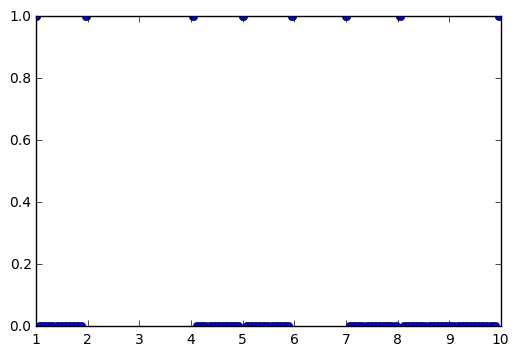

In [73]:
st = SpikeTrain(stdata, fs=1, support=ep2)
print(st.support.time)
bst = BinnedSpikeTrain(st, ds=0.08)

plt.plot(bst.centers, bst.data, 'o')

In [72]:
st.time

array([  1.,   2.,   4.,   5.,   6.,   7.,   8.,  10.])

In [139]:
bins[:-1] + np.diff(bins) / 2

array([ 0.85,  1.19,  1.53,  1.87])

In [140]:
bins

array([ 0.68,  1.02,  1.36,  1.7 ,  2.04])

In [11]:
bins.tolist()

[0.68, 1.02, 1.3599999999999999, 1.7000000000000002, 2.04]

In [26]:
a = np.array((1,2,3))
b = np.array((4,5,6))

In [29]:
np.vstack(a,b).transpose()

TypeError: vstack() takes 1 positional argument but 2 were given